In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_csv('./jokes.csv')

In [3]:
df

,ID,Question,Answer
0,1,Did you hear about the Native American man tha...,He nearly drown in his own tea pee.
1,2,What's the best anti diarrheal prescription?,Mycheexarphlexin
2,3,What do you call a person who is outside a doo...,Matt
3,4,Which Star Trek character is a member of the m...,Jean-Luc Pickacard
4,5,What's the difference between a bullet and a h...,A bullet doesn't miss Harambe
...,...,...,...
38264,38265,Q: Why did the pacifist /b/tard try to calm ev...,He did it for the
38265,38266,Q: Why can't Obama poke fun at himself?,A: Because that would be racist.
38266,38267,Why is gambling not allowed in Africa?,Because there are too many cheetahs.
38267,38268,What do you call three witches in a hot tub?,A self-cleaning coven.


In [4]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    '''
    Clean text by removing unnecessary characters and altering the format of words.
    
    '''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = _removeNonAscii(text)
    text = text.strip()
    
    return text

def tagger(decoder_input_sentence):
    '''
    Tag decoder inputs
    
    '''
    bos = "<BOS> "
    eos = " <EOS>"
    final_target = bos + decoder_input_sentence + eos
    return final_target

In [5]:
df['clean_qn'] = df['Question'].apply(lambda x: clean_text(x))
df['clean_ans'] = df['Answer'].apply(lambda x: clean_text(x))

In [6]:
df.head()

,ID,Question,Answer,clean_qn,clean_ans
0,1,Did you hear about the Native American man tha...,He nearly drown in his own tea pee.,did you hear about the native american man tha...,he nearly drown in his own tea pee
1,2,What's the best anti diarrheal prescription?,Mycheexarphlexin,what is the best anti diarrheal prescription,mycheexarphlexin
2,3,What do you call a person who is outside a doo...,Matt,what do you call a person who is outside a doo...,matt
3,4,Which Star Trek character is a member of the m...,Jean-Luc Pickacard,which star trek character is a member of the m...,jeanluc pickacard
4,5,What's the difference between a bullet and a h...,A bullet doesn't miss Harambe,what is the difference between a bullet and a ...,a bullet does not miss harambe


### Create encoder-decoder text pairs

Here, we have input sequence and  a target sequence. We will have to create separate lists for input sequences and target sequences and we will also need to create lists for unique tokens (input tokens and target tokens) in our dataset.

In [7]:
text_input = df['clean_qn'].tolist()
text_output = df['clean_ans'].tolist()
pairs = list(zip(text_input, text_output))
np.random.shuffle(pairs)

In [8]:
pairs[:1]

[('where do orphans go when they are sick', 'obviously not the family doctor')]

#### Example
input sequence: 'did you hear about dr dank'

target sequence: 'he checked meme out at 420 said i have dope currently blazing it down the highway in his gr8 van creddit 2 my m80'

### Create our vocabulary set

Now we will create a word2idx dictionary that will store our input tokens as key-value pairs, the word being the key and value is the index. Features dictionary will help us encode our sentences into one-hot vectors. To decode the sentences we will need to create the reverse dictionary, idx2word that stores index as a key and word as a value.

For target sequences, we will add ‘<BOS>’ at the beginning of the sequence and ‘<EOS>’ at the end of the sequence so that our model knows where to start and end text generation.

In [9]:
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:
    _, text = line[0], line[1]
    # Redefine target_doc below and append it to target_docs
    target_doc = '<BOS> ' + text + ' <EOS>'
    target_docs.append(target_doc)

from keras.preprocessing.text import Tokenizer

def create_vocab(text_lists, VOCAB_SIZE):
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(text_lists)
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k, v in dictionary.items():
        if v <= VOCAB_SIZE:
            word2idx[k] = v
            idx2word[v] = k
        if v > VOCAB_SIZE-1:
            continue
          
    return word2idx, idx2word

Using TensorFlow backend.


In [44]:
word2idx, idx2word = create_vocab(text_lists=text_input+target_docs, VOCAB_SIZE=15000)

In [45]:
len(word2idx)

15000

### Model Training

To train our seq2seq model we will use three matrices of one-hot vectors:
1. Encoder input data, 
2. Decoder input data
2. Decoder output data

We use two matrices for the Decoder is a method called teacher forcing which is used by the seq2seq model while training. What is the idea behind this? We have an input token from the previous timestep to help the model train for the current target token.

In [46]:
assert idx2word[1] == idx2word[word2idx[idx2word[1]]]
MAX_LEN = 20
VOCAB_SIZE = 15000
def tokenizer(desc, word2idx, max_desc_length=MAX_LEN):
    '''
    Function to tokenize descriptions
    Inputs:
    - text
    - word2idx, dictionary mapping words to their corresponding tokens
    - max_desc_length, used for pre-padding the descriptions where the no. of words is less than this number
    Ouput:
    List of length max_desc_length, pre-padded with zeroes if the desc length was less than max_desc_length
    '''
    a = [word2idx[i] if i in word2idx else 0 for i in desc.split()]
    b = [0] * max_desc_length
    if len(a)<max_desc_length:
        return np.asarray(b[:max_desc_length-len(a)]+a).squeeze()
    else:
        return np.asarray(a[:max_desc_length]).squeeze()

In [47]:
encoder_seq = np.squeeze([tokenizer(x, word2idx) for x in text_input])
decoder_seq = np.squeeze([tokenizer(x, word2idx) for x in target_docs])

In [48]:
decoder_seq

array([[   0,    0,    0, ...,  369,  310,    0],
       [   0,    0,    0, ..., 3437,    0,    0],
       [   0,    0,    0, ...,   15,  643,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,  125,  357,    0],
       [   0,    0,    0, ...,  341,  987,    0]])

In [49]:
EMBEDDING_DIM = 50
def glove_50d_dictionary(GLOVE_DIR):
    embeddings_index = {}
    with open("./glove.6B.50d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    return embeddings_index
word2vec = glove_50d_dictionary('./')

In [50]:
word2vec.get('the'[0])

array([-0.37915 ,  0.61848 ,  0.9593  ,  0.90403 ,  0.36806 ,  0.022972,
        0.16795 , -1.5309  , -0.060533, -0.25    ,  0.15031 ,  0.31967 ,
       -0.68914 , -0.78626 , -0.015825,  0.50531 , -0.8473  , -0.12353 ,
        0.078526, -0.96024 , -0.54313 , -0.33516 ,  0.38932 ,  0.19461 ,
       -1.1688  , -0.86608 , -0.39178 ,  0.24183 ,  0.32862 , -0.78755 ,
        2.4884  ,  0.71015 , -0.53114 ,  0.89593 , -0.23053 , -0.82023 ,
        0.34425 , -0.96866 , -0.15143 , -0.44912 ,  0.89513 , -0.01659 ,
       -0.2749  ,  0.27948 ,  0.77936 , -0.31944 ,  0.16756 , -0.62515 ,
        0.053323,  0.62023 ], dtype=float32)

In [143]:
decoder_seq.shape

(38269, 20)

Reading a pre-trained word embedding and addapting to our vocabulary:

In [58]:
# this time: embedding_dimension = 50d
def embedding_matrix_creater(embedding_dimension):
    embedding_matrix = np.zeros((len(word2idx)+1, embedding_dimension))
    i = 0
    for word in word2idx:
        embedding_vector = word2vec.get(word[0])
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        i+=1
    return embedding_matrix

embedding_matrix = embedding_matrix_creater(EMBEDDING_DIM)

In [59]:
embedding_matrix.shape

(15001, 50)

### Keras Model

In [148]:
from keras.layers import Input, Embedding, LSTM, Dense, RepeatVector, Bidirectional, Dropout, merge, TimeDistributed
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

MAX_LEN = 20
num_samples = 38269
VOCAB_SIZE = 15000
SENTENCE_EMBEDDING_SIZE = 300
WORD_EMBED_SIZE = 50
def build_model(hidden_dim=SENTENCE_EMBEDDING_SIZE, word_embed_size=WORD_EMBED_SIZE, vocab_size=VOCAB_SIZE, embed_matrix=embedding_matrix, max_len=MAX_LEN):
    input_context = Input(shape=(MAX_LEN,), dtype='int32', name='input_context')
    input_answer = Input(shape=(MAX_LEN,), dtype='int32', name='input_answer')
    #Encoder-Decoder
    LSTM_Encoder = LSTM(hidden_dim, return_state=True)
    LSTM_Decoder = LSTM(hidden_dim, return_state=True, return_sequences=True)
    #Embedding layer
    Shared_Embedding = Embedding(output_dim=word_embed_size, 
                                 input_dim=vocab_size+1, 
                                 weights=[embed_matrix], 
                                 input_length=max_len)
    #Encoder
    encoder_embed = Shared_Embedding(input_context)
    encoder_output, state_h, state_c = LSTM_Encoder(encoder_embed)
    encoder_states = [state_h, state_c]
    #Decoder
    decoder_embed = Shared_Embedding(input_answer)
    decoder_output, _, _ = LSTM_Decoder(decoder_embed, initial_state=encoder_states)
    #FC layer
    #merge_layer = merge([encoder_output, decoder_output], mode='concat', concat_axis=1)
    #out = Dense(vocab_size/2, activation="relu")(merge_layer)
    #out = Dense(vocab_size, activation="softmax")(out)
    #Full Model
    #model = Model(input=[input_context, input_answer], output = [out])
    # dense_layer = Dense(VOCAB_SIZE, activation='softmax')
    output = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_output)
    model = Model([input_context, input_answer], output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'], sample_weight_mode='temporal')

    return model
    

In [149]:
model = build_model()
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 20)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 20, 50)       750050      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
lstm_33 (LSTM)                  [(None, 300), (None, 421200      embedding_17[0][0]        

In [62]:
def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
    decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")
    for i, seqs in enumerate(decoder_input_data):
        for j, seq in enumerate(seqs):
            if j > 0:
                decoder_output_data[i,j-1,seq] = 1.
    print(decoder_output_data.shape)
    return decoder_output_data

decoder_output_data = decoder_output_creater(decoder_seq, num_samples, MAX_LEN, VOCAB_SIZE)


(38269, 20, 15000)


In [156]:
model.fit([encoder_seq, decoder_seq], decoder_output_data, batch_size=64, epochs=100)

Epoch 1/100
38269/38269 [==============================] - 539s 14ms/step - loss: 1.9835 - accuracy: 0.7267
Epoch 2/100
38269/38269 [==============================] - 532s 14ms/step - loss: 1.8452 - accuracy: 0.7356
Epoch 3/100
38269/38269 [==============================] - 548s 14ms/step - loss: 1.7658 - accuracy: 0.7396
Epoch 4/100
38269/38269 [==============================] - 556s 15ms/step - loss: 1.7046 - accuracy: 0.7431
Epoch 5/100
38269/38269 [==============================] - 557s 15ms/step - loss: 1.6524 - accuracy: 0.7461
Epoch 6/100
38269/38269 [==============================] - 559s 15ms/step - loss: 1.6058 - accuracy: 0.7492
Epoch 7/100
38269/38269 [==============================] - 560s 15ms/step - loss: 1.5625 - accuracy: 0.7524
Epoch 8/100
38269/38269 [==============================] - 558s 15ms/step - loss: 1.5214 - accuracy: 0.7554
Epoch 9/100
38269/38269 [==============================] - 566s 15ms/step - loss: 1.4826 - accuracy: 0.7581
Epoch 10/100
38269/38269 [==

38269/38269 [==============================] - 533s 14ms/step - loss: 0.6936 - accuracy: 0.8666
Epoch 77/100
38269/38269 [==============================] - 534s 14ms/step - loss: 0.6877 - accuracy: 0.8673
Epoch 78/100
38269/38269 [==============================] - 533s 14ms/step - loss: 0.6825 - accuracy: 0.8683
Epoch 79/100
38269/38269 [==============================] - 533s 14ms/step - loss: 0.6778 - accuracy: 0.8691
Epoch 80/100
38269/38269 [==============================] - 534s 14ms/step - loss: 0.6730 - accuracy: 0.8698
Epoch 81/100
38269/38269 [==============================] - 534s 14ms/step - loss: 0.6675 - accuracy: 0.8710
Epoch 82/100
38269/38269 [==============================] - 535s 14ms/step - loss: 0.6627 - accuracy: 0.8719
Epoch 83/100
38269/38269 [==============================] - 534s 14ms/step - loss: 0.6579 - accuracy: 0.8726
Epoch 84/100
38269/38269 [==============================] - 555s 15ms/step - loss: 0.6535 - accuracy: 0.8733
Epoch 85/100
38269/38269 [======

In [157]:
model.save_weights('model_weights.h5')

In [169]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy'])


In [170]:
loss_history = model.history.history['loss']
acc_history = model.history.history['accuracy']

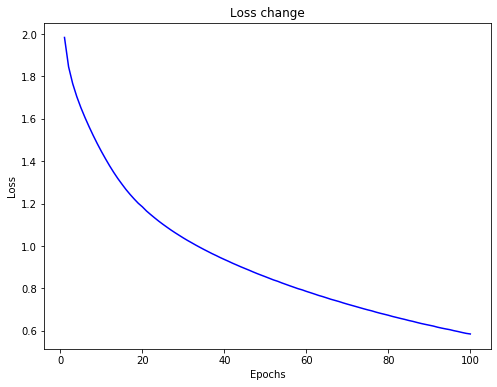

In [178]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
rang = range(1,101)

plt.plot(rang, loss_history,"b")
plt.title('Loss change')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

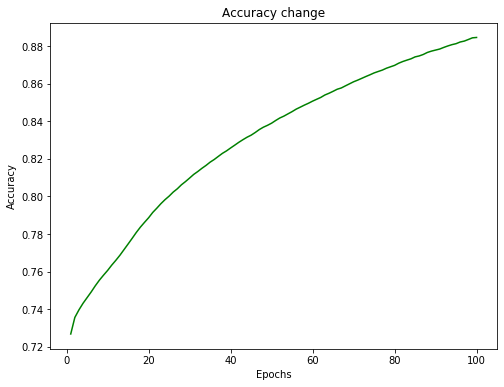

In [184]:
plt.plot(rang, acc_history,"g")
plt.title('Accuracy change')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()